#### NX-414: Brain-like computation and intelligence
##### TA: Alessandro Marin Vargas

# Week 5 - Mini project (Predicting neural activity)

The objectives of the mini project are:
- Learn how to predict neural activity using linear regression from images and from neural network layers.
- Quantify the goodness of the model
- Compare the results across the network layers and between trained/random neural network
- Predict the neural activity using a neural network in a data-driven approach

Specifically, here you will use the data from the following [paper](https://www.jneurosci.org/content/jneuro/35/39/13402.full.pdf). The behavioral experiment consisted in showing to non-human primates some images while recording the neural activity with multielectrode arrays from the inferior temporal (IT) cortex. In the data we provided you, the neural activity and the images are already pre-processed and you will have available the images and the corresponding average firing rate (between 70 and 170 ms) per each neuron.

In [10]:
import sys
!{sys.executable} -m pip install gdown h5py

In [11]:
# run this cell only the first time you run the notebook
run_this_cell = False
if run_this_cell:
    import gdown
    url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
    output = "data/IT_data.h5"
    gdown.download(url, output, quiet=False, fuzzy=True)

In [12]:
# import useful libraries
from utils import *
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

### Load the data

In [13]:
path_to_data = 'data' 
stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)

In [14]:
n_stimulus, n_channels, img_size, _ = stimulus_train.shape
_, n_neurons = spikes_train.shape
print('The train dataset contains {} stimuli and {} IT neurons'.format(n_stimulus,n_neurons))
print('Each stimulus have {} channgels (RGB)'.format(n_channels))
print('The size of the image is {}x{}'.format(img_size,img_size))

The train dataset contains 2592 stimuli and 168 IT neurons
Each stimulus have 3 channgels (RGB)
The size of the image is 224x224


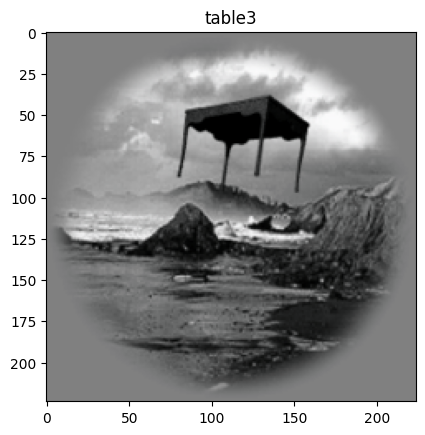

In [15]:
stim_idx = 1

visualize_img(stimulus_train,objects_train,stim_idx)

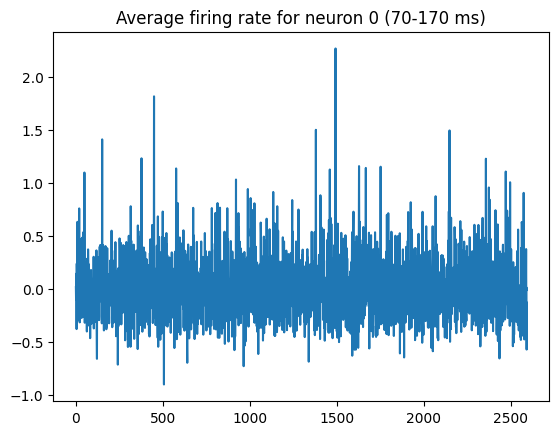

In [16]:
# we can now visualize the neuron response to the different stimuli
neuron_idx = 0

plt.figure()
plt.title('Average firing rate for neuron {} (70-170 ms)'.format(neuron_idx))
plt.plot(spikes_train[:,neuron_idx])
# note that each point represents average respose of the neuron over 100 ms to a different stimulus
# in fact there are 2592 peaks in the plot

## Part 1: Predict the neural activity from pixels

##### Develop a linear regression model that predict the neural activity from pixels.
You can try out different types of linear regression (ridge, least-square regression)

In [38]:
# transform objects to 8 classes and to int
objects_train_8 = transform_classes_to_int(transform_to_8_classes(objects_train))
objects_val_8 = transform_classes_to_int(transform_to_8_classes(objects_val))

# Flatten stimulus data
stimulus_train_res = stimulus_train.reshape((2592, -1))
stimulus_val_res = stimulus_val.reshape((288, -1))

# concatenate the 2 arrays
X_train = np.concatenate((stimulus_train_res, np.array(objects_train_8).reshape(-1,1)), axis=1)
X_val = np.concatenate((stimulus_val_res, np.array(objects_val_8).reshape(-1,1)), axis=1)

print('Shape of X_train: ', X_train.shape)
print('Shape of X_val: ', X_val.shape)


Shape of X_train:  (2592, 150529)
Shape of X_val:  (288, 150529)


In [39]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.metrics import explained_variance_score

# one-hot encode the class labels for the training set
encoder = OneHotEncoder(sparse=False)
class_labels_one_hot = encoder.fit_transform(X_train[:,-1].reshape(-1, 1))

# one-hot encode the class labels for the validation set
class_labels_one_hot_val = encoder.transform(X_val[:,-1].reshape(-1, 1))

# concatenate the one-hot encoded labels to the feature matrix
X_train_augmented = np.hstack((X_train[:,:-1], class_labels_one_hot))
X_val_augmented = np.hstack((X_val[:,:-1], class_labels_one_hot_val))

# fit ridge regression model to augmented data
ridge = Ridge(alpha=10, fit_intercept=True)
ridge.fit(X_train_augmented, spikes_train)

# make predictions using validation set
y_pred = ridge.predict(X_val_augmented)

##### Evaluate your prediction (Check both the correlation and explained variance for each neuron). Plot the distribution for the explained variance across neurons.

Overall explained variance: -1.0879108856427018
Overall correlation: 0.1558793738704406


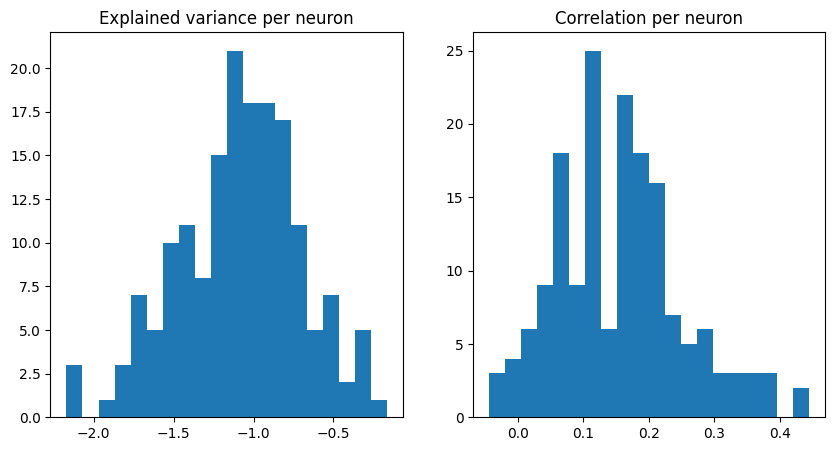

In [41]:
# Explained variance
ev_per_neuron = explained_variance_score(spikes_val, y_pred, multioutput='raw_values')
overall_ev = np.mean(ev_per_neuron)
print('Overall explained variance:', overall_ev)

# Correlation between predicted values and real values 
corr_per_neuron = compute_corr(spikes_val, y_pred, divide = True)
overall_corr = compute_corr(spikes_val, y_pred)
print('Overall correlation:', overall_corr)

# print histogram of explained variance per neuron
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# print histogram of explained variance per neuron
ax = axs[0]
ax.hist(ev_per_neuron, bins=20)
ax.set_title('Explained variance per neuron')

# print histogram of correlation per neuron
ax = axs[1]
ax.hist(corr_per_neuron, bins=20)
ax.set_title('Correlation per neuron')

plt.show()

##### Predicting from pixels is very hard and the model is likely to overfit. An image is very high-dimensional, try to retain the corresponding 1000 PCs and use them to predict the neural activity. 

In [20]:
# perform PCA
n_comp = 1000

pca = PCA(n_components=n_comp)
pca.fit(stimulus_train_res)
pca_filters = pca.components_
pca_features_train = pca.transform(stimulus_train_res)

# Take 1000 PCs for the validation set as well
pca_features_val = pca.transform(stimulus_val_res)


In [21]:
# concatenate the one-hot encoded labels to the feature matrix
pca_features_train_aug= np.hstack((pca_features_train, class_labels_one_hot))
pca_features_val_aug = np.hstack((pca_features_val, class_labels_one_hot_val))

Overall explained variance: 0.03667225646208912
Overall correlation: 0.3509930539669722


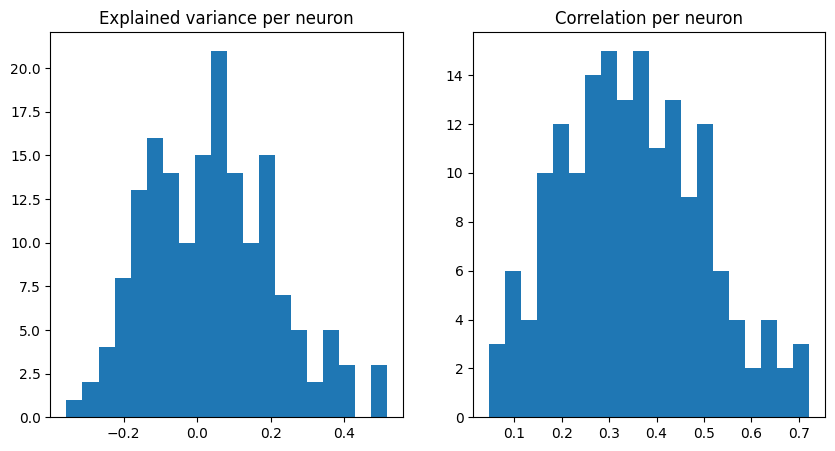

In [22]:
from sklearn.linear_model import Ridge
from sklearn.metrics import explained_variance_score

# fit ridge regression model with arbitrary lambda: 10
num_classes = 8
lamb = 10
ridge = Ridge(alpha=lamb, fit_intercept=True)
ridge.fit(pca_features_train_aug, spikes_train)

# make predictions using validation set
y_pred = ridge.predict(pca_features_val_aug)

# Explained variance
ev_per_neuron = explained_variance_score(spikes_val, y_pred, multioutput='raw_values')
overall_ev = np.mean(ev_per_neuron)
print('Overall explained variance:', overall_ev)

# Correlation between predicted values and real values 
corr_per_neuron = compute_corr(spikes_val, y_pred, divide = True)
overall_corr = compute_corr(spikes_val, y_pred)
print('Overall correlation:', overall_corr)

# Pltot results
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# print histogram of explained variance per neuron
ax = axs[0]
ax.hist(ev_per_neuron, bins=20)
ax.set_title('Explained variance per neuron')

# print histogram of correlation per neuron
ax = axs[1]
ax.hist(corr_per_neuron, bins=20)
ax.set_title('Correlation per neuron')

plt.show()


##### Can we improve the prediction? Using the ridge regression, find the best parameter with cross-fold validation (remember to split the data keeping the same distribution of classes between the train and validation set). Does it get better?

In [42]:
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm 

# number of classes
num_classes = 8


# define the splitter object
splitter = StratifiedKFold(n_splits=20)



# initialize lists to store the results
best_lambda_per_neuron = []
best_ev_per_neuron = []

# create candidate lambda values
lambdas = [0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000]

# loop over different neurons
for neuron in tqdm(range(spikes_train.shape[1])):
    best_ev = -5
    best_lamb = 0

    # loop over different lambda values
    
    for lamb in lambdas:
        evs = []
        # split into training and validation sets
        for (train_index, val_index) in splitter.split(pca_features_train, objects_train_8):
            # split the data into training and validation sets
            X_train, X_val = pca_features_train_aug[train_index,:], pca_features_train_aug[val_index,:]
            y_train, y_val = spikes_train[train_index, neuron], spikes_train[val_index, neuron]
                
            # fit ridge regression model to X_train after one-hot encoding the class labels
            ridge = Ridge(alpha=lamb, fit_intercept=True)
            ridge.fit(X_train, y_train)
            
            # make predictions using validation set
            y_pred = ridge.predict(X_val)
            
            # compute the ev for each neuron on the val set 
            ev_per_neuron = explained_variance_score(y_val, y_pred)
            evs.append(ev_per_neuron)
            #print('Explained variance for neuron {0} and lambda = {1}: {2} '.format(neuron, lamb, ev_per_neuron))
        ev = np.mean(evs)
        if ev > best_ev:
            best_ev = ev
            best_lamb = lamb
    
    best_ev_per_neuron.append(best_ev)
    best_lambda_per_neuron.append(best_lamb)
        
    #print('Explained variance for neuron {0} and lambda = {1}: {2} '.format(neuron, best_lamb, best_ev))

100%|██████████| 168/168 [33:26<00:00, 11.94s/it]


100%|██████████| 168/168 [00:09<00:00, 16.90it/s]


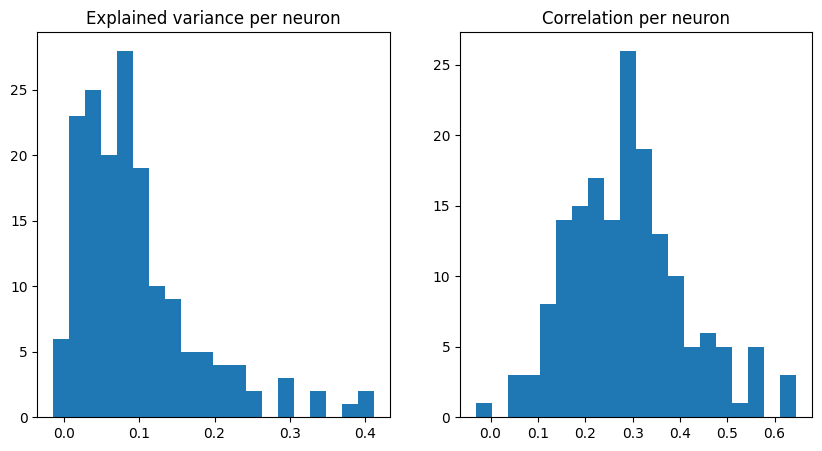

Average explained variance: 0.09490798456521646
Average correlation: 0.2899846223897023


In [44]:
# now use the best lambda for each neuron to fit the model on the entire training set
# and evaluate it on the validation set

num_classes = 8
ev_per_neuron = []
corr_per_neuron = []
for neuron in tqdm(range(spikes_train.shape[1])):
    #lamb = lambdas[best_lam[neuron]]
    lamb = best_lambda_per_neuron[neuron]
    ridge = Ridge(alpha=lamb, fit_intercept=True)
    ridge.fit(pca_features_train_aug, spikes_train[:, neuron])

    # make predictions using validation set
    y_pred = ridge.predict(pca_features_val_aug)

    # compute explained variance
    ev = explained_variance_score(spikes_val[:,neuron], y_pred)
    ev_per_neuron.append(ev)
        
    # compute the correlation for each neuron
    corr = np.corrcoef(y_pred, spikes_val[:, neuron], rowvar=False)[0, 1]
    #corr = np.mean(corr)
    corr_per_neuron.append(corr)

# create subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# print histogram of explained variance per neuron
ax = axs[0]
ax.hist(ev_per_neuron, bins=20)
ax.set_title('Explained variance per neuron')

# print histogram of correlation per neuron
ax = axs[1]
ax.hist(corr_per_neuron, bins=20)
ax.set_title('Correlation per neuron')

plt.show()

# print the average explained variance and correlation
print('Average explained variance:', np.mean(ev_per_neuron))
print('Average correlation:', np.mean(corr_per_neuron))

In [ ]:
# most of the best lambdas resulted to take the maximum value we specified (i.e., 100)
# indicating that if we included even larger values for the lambda parameters (>100) they 
# would probably be selected in the regression. However, the lambda parameter determines the strength 
# of the regularization penalty applied to the coefficients, and 100 is already very large,
# meaning that the coefficients have already been shrinked towards zero.
# As a matter of fact, from the above results, we can see that despite the tuned lambdas, 
# the model haven't got much better than before, suggesting thatthe model is not 
# able to generalize well enough to new data. 

### Part 2: Predict the neural activity with the task-driven modeling approach

As you have seen in the class, the underlying hypothesis of task-driven modeling is that training the network to perform a relevant behavioral task makes the network to develop representations that resemble the ones of the biological brain. Let's test this hypothesis by loading a pre-trained ResNet50 model and use the activations of each layer to predict the neural activity. Follow these steps:

- Give as input to the network the stimuli and extract the corresponding activations of the following layers ['conv1','layer1','layer2','layer3','layer4','avgpool']
- Compute the 1000 PCs for each layer activation. (Careful that you don't want to store all activations together at the same time because it won't fit in the memory. Therefore, compute the activations and corresponding PCs for each layer and store only the computed PCs).
- Use the PCs of each layer to predict the neural activity using the linear regression models you developed before.
- Compute the goodness of fit using the correlation and explained variance metrics. Do you predict the neural activity better than before?
- Plot the distribution of explained variance with respect to the layer of the network (order them based on the depth). How does the neural activity changes across the model layers, can you make some statements about it?
- Compare the predictions that you obtained using one layer of the pretrained model and the one obtained using the same layer but from a randomly initialized model. Which network can better predict the neural activity and why?

In [51]:
import torch
import torch.utils.data as data
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.decomposition import PCA
import numpy as np
from tqdm import tqdm

# note that instead of running this cell (which takes around 30 min) 
# one can take directly the PCs of the activations for the layers 
# from data/activationsResNet50 

# if you want to run the model and extrapolate activations again set 'run_model' to True 


run_model = False 

if run_model:
    weights = ResNet50_Weights.IMAGENET1K_V2
    model = resnet50(weights=weights)
    model.eval()

    # placeholders for predictions and features
    batch_size = 64
    layers = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool']
    num_components = 1000

    data_loader = data.DataLoader(stimulus_train, batch_size=batch_size, shuffle=False)
    data_loader_val = data.DataLoader(stimulus_val, batch_size=batch_size, shuffle=False)

    pca_dict_train= {}
    pca_dict_val = {}

    for name in tqdm(layers):
        pca_dict_train[name] = []
        hook = getattr(model, name).register_forward_hook(lambda m, i, o: pca_dict_train[name].append(o.detach().numpy()))

        with torch.no_grad():
            for batch in data_loader:
                x = np.stack(batch).astype(np.float32)
                x = torch.from_numpy(x)
                preds = model(x)

            layer_output = np.concatenate(pca_dict_train[name], axis=0)

        hook.remove()

        # same for the validation test 
        pca_dict_val[name] = []
        hook_val = getattr(model, name).register_forward_hook(lambda m, i, o: pca_dict_val[name].append(o.detach().numpy()))

        with torch.no_grad():
            for batch in data_loader_val:
                x = np.stack(batch).astype(np.float32)
                x = torch.from_numpy(x)
                preds = model(x)

            layer_output_val = np.concatenate(pca_dict_val[name], axis=0)

        hook_val.remove()


        # compute pca (fit on train and transform both train an val)
        pca = PCA(n_components=num_components)
        pca.fit(layer_output.reshape(layer_output.shape[0], -1))
        pca_dict_train[name] = pca.transform(layer_output.reshape(layer_output.shape[0], -1))
        pca_dict_val[name] = pca.transform(layer_output_val.reshape(layer_output_val.shape[0], -1))


    with open(os.path.join("data/activationsResNet50", "pca_dict_train.pkl"), "wb") as f:
        pickle.dump(pca_dict_train, f)

    with open(os.path.join("data/activationsResNet50", "pca_dict_val.pkl"), "wb") as f:
        pickle.dump(pca_dict_val, f)

else:
    pca_dict_train = load_pickle_dict('data/activationsResNet50/pca_dict_train.pkl')
    pca_dict_val = load_pickle_dict('data/activationsResNet50/pca_dict_val.pkl')
    

    

100%|██████████| 6/6 [16:43<00:00, 167.19s/it]


In [52]:
# feed these results to ridge regression 
from sklearn.linear_model import Ridge
from sklearn.metrics import explained_variance_score, r2_score
import matplotlib.pyplot as plt

layers = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool']

ev_layer = []
corr_per_neuron_layer = {}
corr_layer = []

for name in layers:
    
    # prepare the data
    X_train = pca_dict_train[name]
    X_val = pca_dict_val[name]
    y_train = spikes_train
    y_val = spikes_val
    
    # fit Ridge Regression Model 
    ridge = Ridge(alpha=20, fit_intercept=True)
    ridge.fit(X_train, y_train)
    y_val_pred = ridge.predict(X_val)
    
    # predict on validation set
    y_val_pred = ridge.predict(X_val)
    # Compute explained variance and correlation on validation set
    ev_layer.append(explained_variance_score(y_val, y_val_pred))
    corr_per_neuron_layer[name] = compute_corr(y_val, y_val_pred, divide = True)
    corr_layer.append(compute_corr(y_val, y_val_pred))
     

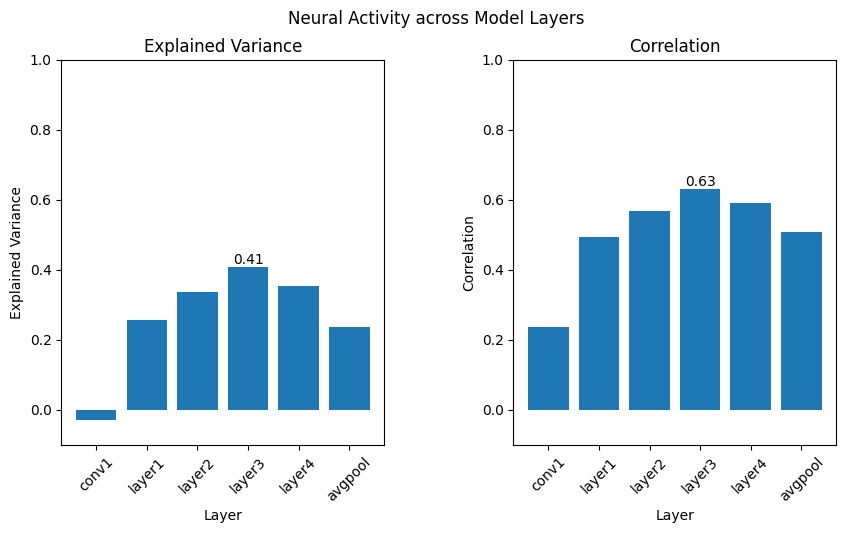

In [53]:
# Plot explained variance
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].bar(layers, ev_layer)
axs[0].set_title('Explained Variance')
axs[0].set_ylim(-0.1, 1)
# Add a label to the top of the second bar
axs[0].text(3,  ev_layer[3]+.01, str( np.round(ev_layer[3], 2)), ha='center', fontsize=10)

# Plot correlation
axs[1].bar(layers, corr_layer)
axs[1].set_title('Correlation')
axs[1].set_ylim(-0.1, 1)
axs[1].text(3,  corr_layer[3]+.01, str( np.round(corr_layer[3], 2)), ha='center', fontsize=10)


# Set x axis label and tick rotation
for ax in axs:
    ax.set_xlabel('Layer')
    ax.tick_params(axis='x', rotation=45)
    
# Set y axis label
axs[0].set_ylabel('Explained Variance')
axs[1].set_ylabel('Correlation')

# Set plot title and adjust subplot spacing
fig.suptitle('Neural Activity across Model Layers')
fig.subplots_adjust(wspace=0.4)

plt.show()

In [54]:
corr_layer

[0.23633394802092936,
 0.49343661765580765,
 0.56795544430159,
 0.6293421251037314,
 0.5905662469209891,
 0.5085466480115387]

In [55]:
# the goodness of fit is far better from before. Based on the ev scores and corr scores for the Resnet50 layers, 
# it seems that the neural activity becomes more discriminative as we move towards the higher layers.
# Specifically, the ev scores increase as we move from 'conv1' to 'layer4' before dropping off slightly for the 'avgpool' layer. 
# This suggests that the neural activity becomes increasingly specialized for the task at hand (presumably image classification) 
# as we move through the layers of the model.



In [34]:
# with randomly initialized weights:
import torch
import torch.nn as nn
import torch.utils.data as data
from torchvision.models import resnet50
from sklearn.decomposition import PCA
import numpy as np
from tqdm import tqdm

# Define the model with randomly initialized weights
model = resnet50(weights=None)

# placeholders for predictions and features
batch_size = 64
layers = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool']
num_components = 1000

data_loader = data.DataLoader(stimulus_train, batch_size=batch_size, shuffle=False)
data_loader_val = data.DataLoader(stimulus_val, batch_size=batch_size, shuffle=False)

pca_dict_train_rndw= {}
pca_dict_val_rndw = {}

for name in tqdm(layers):
    pca_dict_train_rndw[name] = []
    hook = getattr(model, name).register_forward_hook(lambda m, i, o: pca_dict_train_rndw[name].append(o.detach().numpy()))

    with torch.no_grad():
        for batch in data_loader:
            x = np.stack(batch).astype(np.float32)
            x = torch.from_numpy(x)
            preds = model(x)

        layer_output = np.concatenate(pca_dict_train_rndw[name], axis=0)
    
    hook.remove()
    
    # same for the validation test 
    pca_dict_val_rndw[name] = []
    hook_val = getattr(model, name).register_forward_hook(lambda m, i, o: pca_dict_val_rndw[name].append(o.detach().numpy()))

    with torch.no_grad():
        for batch in data_loader_val:
            x = np.stack(batch).astype(np.float32)
            x = torch.from_numpy(x)
            preds = model(x)

        layer_output_val = np.concatenate(pca_dict_val_rndw[name], axis=0)
    
    hook_val.remove()

    
    # compute pca (fit on train and transform both train an val)
    pca = PCA(n_components=num_components)
    pca.fit(layer_output.reshape(layer_output.shape[0], -1))
    pca_dict_train_rndw[name] = pca.transform(layer_output.reshape(layer_output.shape[0], -1))
    pca_dict_val_rndw[name] = pca.transform(layer_output_val.reshape(layer_output_val.shape[0], -1))


100%|██████████| 6/6 [2:02:57<00:00, 1229.50s/it]  


In [37]:
# compare the prediction obtained for layer 3 in both cases (imagenetik weights and random weights)

name = 'layer3'

X_train = pca_dict_train[name]
X_train_rndw = pca_dict_train_rndw[name]

X_val = pca_dict_val[name]
X_val_rndw = pca_dict_val_rndw[name]

y_train = spikes_train
y_val = spikes_val



ridge = Ridge(alpha=20, fit_intercept=True)
ridge.fit(X_train, y_train)
y_val_pred = ridge.predict(X_val)
ev = explained_variance_score(y_val, y_val_pred)
corr = compute_corr(y_val, y_val_pred)

ridge_rndw = Ridge(alpha=20, fit_intercept=True)
ridge_rndw.fit(X_train_rndw, y_train)
y_val_pred_rndw = ridge.predict(X_val_rndw)
ev_rndw = explained_variance_score(y_val, y_val_pred_rndw)
corr_rndw = compute_corr(y_val, y_val_pred_rndw)


print('Explained variance for imagenetik weights is:', ev)
print('Explained variance for random weights is:', ev_rndw)

print('Correlation for imagenetik weights is:', corr)
print('Correlation for random weights is:', corr_rndw)

# hence the imagenetik is performing far better.comment on this 
 


Explained variance for imagenetik weights is: 0.40968523777666543
Explained variance for random weights is: -1.3570236563682556
Correlation for imagenetik weights is: 0.6313046779777112
Correlation for random weights is: 0.011449338795902679


In [56]:
# Based on the results you provided, it seems that the ResNet50 model with imagenetik_v2 weights performs significantly 
#better than the model with randomly initialized weights for layer 3.

#The explained variance (EV) for the model with imagenetik_v2 weights is 0.409, whereas for the model with randomly 
#initialized weights it is -1.357. The higher the explained variance, the better the model is at predicting the neural activity. 
#In this case, the model with imagenetik_v2 weights has a positive EV, indicating that it can explain some of the variance in the 
#neural activity. On the other hand, the model with randomly initialized weights has a negative EV, which means that it performs 
#worse than simply using the mean of the neural activity as a predictor.

#The correlation (Corr) for the model with imagenetik_v2 weights is 0.631, which indicates a strong positive relationship between 
#the predicted and actual neural activity. In contrast, the correlation for the model with randomly initialized weights is only 0.011, 
#which suggests a weak and practically insignificant relationship.

#Therefore, based on these results, we can conclude that the ResNet50 model with imagenetik_v2 weights is better suited to predict 
#neural activity in layer 3 compared to the model with randomly initialized weights. This may be due to the fact that the imagenetik_v2 weights 
#were pre-trained on a large dataset, allowing the model to learn more general features that are useful for predicting neural activity. 
#In contrast, the randomly initialized weights do not provide any useful prior information for the model to learn from.